# Wine

## Required Packages

In [1]:
import random
import math
import collections
import string

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer

seed = 42
random.seed(seed)
np.random.seed(42)

## Read and Split Data

In [2]:
# Read the data
df = pd.read_csv('./data/winemag-data-130k-v2.csv')
print(f'Columns: {list(df.columns)}')
print(f'N Rows: {len(df.index)}')

# split it into train, dev, and test
# courtesy of https://stackoverflow.com/a/38251063
perm = np.random.permutation(df.index)
m = len(df.index)

train_percent = .6
dev_percent = .2

train_end = int(m * train_percent)
dev_end = int(m * dev_percent) + train_end

train_df = df.iloc[perm[:train_end]]
dev_df = df.iloc[perm[train_end:dev_end]]
test_df = df.iloc[perm[dev_end:]]

print(f'Train shape: {train_df.shape}')
print(f'Dev shape: {dev_df.shape}')
print(f'Test shape: {test_df.shape}')

Columns: ['Unnamed: 0', 'country', 'description', 'designation', 'points', 'price', 'province', 'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title', 'variety', 'winery']
N Rows: 129971
Train shape: (77982, 14)
Dev shape: (25994, 14)
Test shape: (25995, 14)


## Initial Investigation
Let's start by just looking at the data and seeing what pops out to us. We'll spend a little time looking at the continuous values points and price, and then spend more time looking at the words

In [3]:
train_df.describe(include='all')

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
count,77982.000000,77943,77982,55330,77982.000000,72568.000000,77943,65329,30329,62232,59215,77982,77981,77982
unique,NaN,42,74320,27151,NaN,NaN,393,1146,17,19,15,73824,644,14410
top,NaN,US,"Seductively tart in lemon pith, cranberry and ...",Reserve,NaN,NaN,California,Napa Valley,Central Coast,Roger Voss,@vossroger,Segura Viudas NV Extra Dry Sparkling (Cava),Pinot Noir,Wines & Winemakers
freq,NaN,32688,3,1247,NaN,NaN,21743,2670,6736,15417,15417,7,7942,140
mean,64948.374048,NaN,NaN,NaN,88.450155,35.465274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,37442.642506,NaN,NaN,NaN,3.046516,41.103730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN,80.000000,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,32697.250000,NaN,NaN,NaN,86.000000,17.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,64754.000000,NaN,NaN,NaN,88.000000,25.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,97368.000000,NaN,NaN,NaN,91.000000,42.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Points

It appears that the points are located between 80-100. This matches up with the source of the data that claims they do not publish reviews for any wine scored less than 80. More information on wine scoring can be viewed [here](https://www.winespectator.com/articles/scoring-scale)

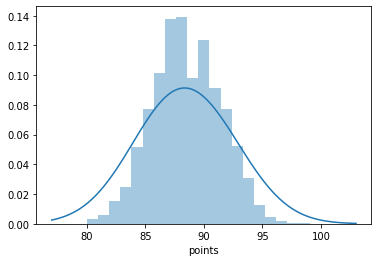

In [4]:
_ = sns.distplot(train_df.points, bins=21, kde_kws={'bw':1})

So it looks like this is a textbook normal distribution with an incredibly slight left skew. Let's just make sure that every value is represented.

In [5]:
print(np.sort(train_df.points.unique()))

[ 80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100]


Any missing values?

In [6]:
train_df.points.isna().sum()

0

### Price

Since this is related to currency, I bet my lunch this is a heavy tailed distribution. Let's see.

Missing values: 5414


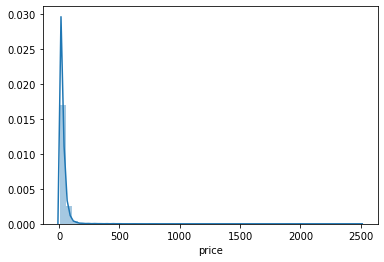

In [7]:
print(f'Missing values: {train_df.price.isna().sum()}')

# let's remove the missing prices for now
sns.distplot(train_df[~train_df.price.isna()].price)

Nice... lets log scale this.

/opt/miniconda3/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


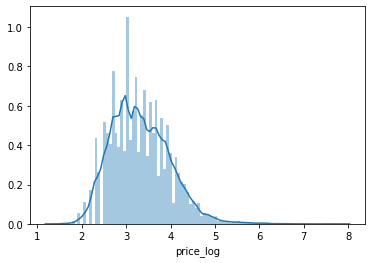

In [8]:
train_df['price_log'] = np.log(train_df.price)
ax = sns.distplot(train_df[~train_df.price_log.isna()].price_log, bins=100)

Just out of curiosity, I see that the lowest price is 4 dollars... what's the score on those?

In [9]:
train_df[train_df.price == 4].points.mean()

84.2

### String Columns

In [10]:
non_cont_columns = train_df.columns[train_df.dtypes == np.object]
print(f'Non-Continuous columns: {list(non_cont_columns)}')

Non-Continuous columns: ['country', 'description', 'designation', 'province', 'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title', 'variety', 'winery']


Let's start by focusing on the descriptions. We'll tokenize, canonize, construct a vocabulary, and finally get counts for each of the items.

In [ ]:
counter = collections.Counter()

for s in train_df.description:
    s = s.lower()
    tokenized = nltk.tokenize.word_tokenize(s)
    counter.update(tokenized)

vocab = counter.items()
print(len(vocab))

In [ ]:
# view most common words 
most_common = counter.most_common(25)
print(most_common)

One very interesting thing viewed here is that in the most common words are very wine specific words. This is pretty obvious in hindsight, but it made me laugh to see wine just outside of the top 10.

### Tasters
Now let's look at the tasters. We'll see how many there are, and the distribution of the number of reviews each has given

In [ ]:
tasters = train_df.taster_name.dropna().unique()
print(f'{len(tasters)} Tasters: {list(tasters)}')
train_df.taster_name = train_df.taster_name.astype('category')

taster_counts  = train_df.taster_name.value_counts()
ax = sns.countplot(train_df.taster_name, order=taster_counts.index)
_ = ax.set_xticklabels(taster_counts.index, rotation=90)

As expected, there appears to be a Zeta distribution in the contributions of each taster. Let's what the numbers are on the 3 least active contributors: Carrie Dykes, Fiona Adams, and Christina Pickard.

In [ ]:
print(taster_counts[['Carrie Dykes', 'Fiona Adams', 'Christina Pickard']])

We'll need to keep this in mind for subsequent analysis since the data related to their contributions will likely not be as representative as someone on the center or left of the distribution

#### Taster Vocabulary
Just for funsies, let's look at the vocabulary of each individual taster

In [ ]:
taster_vocabs = {n: collections.Counter() for n in tasters}

for _, row in train_df[~train_df.taster_name.isna()].iterrows():
    taster = row.taster_name
    s = row.description
    s = s.lower()
    tokenized = nltk.tokenize.word_tokenize(s)
    taster_vocabs[taster].update(tokenized)

In [ ]:
taster_vocab_lens = {k: len(v.items()) for k, v in taster_vocabs.items()}
taster_vocab_lens = pd.Series(taster_vocab_lens).sort_values().iloc[::-1]

ax = sns.barplot(x=taster_vocab_lens.index, y=taster_vocab_lens)
_ = ax.set_xticklabels(taster_vocab_lens.index, rotation=90)

As expected, Roger Voss is up top since he has had the most opportunity to use unique words. Let's compare the two lists.

In [ ]:
compare_list = []

contribution_count_list = list(taster_counts.index)

print('Vocab Size compared to Contribution:')
for vocab_idx, taster in enumerate(taster_vocab_lens.index):
    count_idx = contribution_count_list.index(taster)
    diff = count_idx - vocab_idx
    print(f'\t{vocab_idx + 1}: {taster} ({diff:+d})')

Kerin O'Keefe appears to be relatively bland in her word usage. 

#### Taster Score Distribution
Let's look at each reviewer's score distribution to make sure we don't have any biased reviewers

In [ ]:
cols = 4
rows = math.ceil(len(tasters) / float(cols))
figs, axes = plt.subplots(rows, cols, figsize=(20,20))
axes = axes.flatten()
for taster, ax in zip(tasters, axes):
    taster_reviews = train_df[train_df.taster_name == taster]
    ax = sns.distplot(taster_reviews.points, ax=ax, bins=20)
    ax.set_title(taster)

plt.tight_layout()

There isn't any bias immediately apparent for any of the reviewers, although this is difficult to ascertain due to the large range in the number of reviews per taster.

#### Taster Price Distribution

And now let's look at the distribution of the log price for each reviewer

In [ ]:
cols = 4
rows = math.ceil(len(tasters) / float(cols))
figs, axes = plt.subplots(rows, cols, figsize=(20,20))
axes = axes.flatten()
for taster, ax in zip(tasters, axes):
    taster_reviews = train_df[(train_df.taster_name == taster) & ~train_df.price_log.isna()]
    ax = sns.distplot(taster_reviews.price_log, ax=ax, bins=20)
    ax.set_title(taster)

plt.tight_layout()

### Unique Words
Let's look at the top 3 unique words used by the tasters. We'll do this by iteratively constructing of the top 3 words used by each taster and removing any duplicate words across top 3 lists.

In [ ]:
stop_words = nltk.corpus.stopwords.words('english')

# collect the top 25 words from the corpus (not including nltk stop words)
top_domain_specific_words = []
n = 25
for word, count in counter.most_common():
    if word in stop_words:
        continue
    
    top_domain_specific_words.append(word)
    if len(top_domain_specific_words) == n:
        break
        
all_stop_words = list(string.punctuation) + top_domain_specific_words + stop_words

n = 3
top_vocab = {}
for taster_name in taster_vocabs:
    taster_vocab = taster_vocabs[taster_name]
    
    unique_words = []
    for word, count in taster_vocab.most_common():
        if word in all_stop_words:
            continue
        
        unique_words.append(word)
        if len(unique_words) == n:
            break
        
    top_vocab[taster_name] = unique_words
        
for taster_name, words in top_vocab.items():
    print(f'{taster_name}: ')
    for i, w in enumerate(words):
        print(f'\t{i+1}: {w}')

Let's see what words are most strongly correlated with price

In [ ]:
vec = CountVectorizer(
    lowercase=True,
    stop_words=stop_words,
    ngram_range=(1,1),
    min_df=10
)
X = vec.fit_transform(train_df.description)
print(len(vec.vocabulary_))

In [ ]:
points_np = np.expand_dims(train_df.points, axis=0)
X_arr = X.toarray().T
points_np = np.concatenate([X_arr, points_np], axis=0)
corr_mtx = np.corrcoef(points_np)

In [ ]:
score_corr = corr_mtx[-1][:-1]

# clear up some memory
del points_np
del X_arr
del corr_mtx

In [ ]:
corr_sorted_idx = np.argsort(score_corr)

n = 10
vocab_words = list(vec.vocabulary_.keys())
print('Highest correlations:')
for i, idx in enumerate(corr_sorted_idx[-1:-n:-1]):
    corr = score_corr[idx]
    word = vocab_words[idx]
    print(f'\t{i+1}. {word}: {corr}')
    
print('Lowest correlations:')
for i, idx in enumerate(corr_sorted_idx[:n]):
    corr = score_corr[idx]
    word = vocab_words[idx]
    print(f'\t{i+1}. {word}: {corr}')